# Simple Harmonic Motion

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

## Set Seed Here

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

## Set Parameters here

In [3]:
min_delta = 0
patience = 20

## Get the test set

In [290]:
test_set = torch.load('data/SHM_test_set.pt')

In [291]:
print(test_set.shape)  # (bs, time, [q, p, dq, dp, ddq, time])

# for i in range(100):
#     plt.scatter(test_set[i, :, 0], test_set[i, :, 1])

torch.Size([100, 500, 6])


## Get the training set

In [65]:
training_set = torch.load('data/SHM_training_set.pt')

torch.Size([1000, 7, 6])


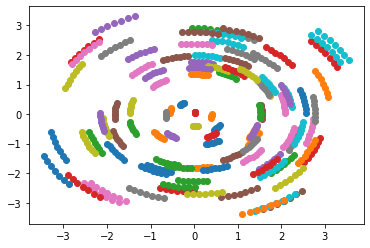

In [67]:
print(training_set.shape)  # (bs, time, [q, p, dq, dp, ddq, time])

for i in range(100):
    plt.scatter(training_set[i, :, 0], training_set[i, :, 1])

## Define dataloader

In [8]:
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl

In [9]:
class DataModule(pl.LightningDataModule):
    def __init__(self, dataset: torch.Tensor, num_sample: int, batch_size = 128):
        super().__init__()
        self.num_sample = num_sample
        self.dataset = dataset[:num_sample, :, :]
        self.batch_size = 128
        
        self.train_set = None
        self.val_set = None
    
    def setup(self):
        q_p, dq_dp, ddq, t = torch.split(self.dataset, [2, 2, 1, 1], dim=2)
        dataset = TensorDataset(q_p, dq_dp, ddq, t)
        
        num_val = int(np.ceil(self.num_sample * 0.2))
        num_train = self.num_sample - num_val
        self.train_set, self.val_set = random_split(dataset, [num_train, num_val])

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)

In [10]:
dataModule = DataModule(training_set, 1000)
dataModule.setup()

### Define Models

In [7]:
from torchdyn.models import NeuralODE

from module import LNN, HNN, LNNODE, Baseline
from nn import MLP, PSD, MatrixNet

In [8]:
def create_models():
    baseline = MLP([2, 32, 32, 2], activation='tanh')

    baselinefunc =  MLP([2, 32, 32, 2], activation='tanh')
    baselineODE = NeuralODE(baselinefunc, sensitivity='adjoint', solver='rk4').to(device)

    hamFunc2 = HNN(num_angle=0, hamiltonianNet=MLP([2, 32, 33, 1], activation='tanh'))
    hamGrad = NeuralODE(hamFunc2, sensitivity='adjoint', solver='rk4').to(device)
    
    lagFunc2 = LNN(num_angle=0, lagrangianNet=MLP([2, 32, 33, 1], activation='softplus'))
    lagGrad = NeuralODE(lagFunc2, sensitivity='adjoint', solver='rk4').to(device)
    
    hamFunc = HNN(num_angle=0, hamiltonianNet=MLP([2, 32, 33, 1], activation='tanh'))
    hamODE = NeuralODE(hamFunc, sensitivity='adjoint', solver='rk4').to(device)

    lagFunc = LNN(num_angle=0, lagrangianNet=MLP([2, 32, 33, 1], activation='softplus'))
    lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver='rk4').to(device)

    massMatrixNet = PSD([1, 32, 16, 1], activation='tanh')
    potentialNet = MLP([1, 32, 16, 1], activation='tanh')

    symFunc = LNNODE(num_angle=0, massMatrixNet=massMatrixNet, potentialNet=potentialNet)
    symGrad = NeuralODE(symFunc, sensitivity='adjoint', solver='rk4').to(device)
    
    massMatrixNet2 = PSD([1, 32, 16, 1], activation='tanh')
    potentialNet2 = MLP([1, 32, 16, 1], activation='tanh')
    
    symFunc2 = LNNODE(num_angle=0, massMatrixNet=massMatrixNet2, potentialNet=potentialNet2)
    symODE = NeuralODE(symFunc2, sensitivity='adjoint', solver='rk4').to(device)

    models = [baseline, baselineODE, hamGrad, lagGrad, hamODE, lagODE, symGrad, symODE]
    return models

In [27]:
import copy
device = 'cpu'
def create_models():
    cNet = MatrixNet([3, 32, 32, 2], control_dim=1, activation='relu')

    baseline = Baseline(num_angle=1, num_raw=1, num_control=1,
                        ODENet=MLP([5, 128, 62, 32, 4], activation='sigmoid'), controlNet=copy.deepcopy(cNet))

    baselineODE = NeuralODE(copy.deepcopy(baseline), sensitivity='adjoint', solver='rk4').to(device)
    baselineODE_grad = NeuralODE(copy.deepcopy(baseline), sensitivity='adjoint', solver='rk4').to(device)
    baselineODE_fd = NeuralODE(copy.deepcopy(baseline), sensitivity='adjoint', solver='rk4').to(device)

    hamFunc = HNN(num_angle=1,
                  hamiltonianNet=MLP([5, 128, 64, 32, 1], activation='softplus'), controlNet=copy.deepcopy(cNet))

    hamODE = NeuralODE(copy.deepcopy(hamFunc), sensitivity='adjoint', solver='rk4').to(device)
    hamODE_grad = NeuralODE(copy.deepcopy(hamFunc), sensitivity='adjoint', solver='rk4').to(device)
    hamODE_fd = NeuralODE(copy.deepcopy(hamFunc), sensitivity='adjoint', solver='rk4').to(device)

    lagFunc = LNN(num_angle=1,
                  lagrangianNet=MLP([5, 128, 64, 32, 1], activation='softplus'), controlNet=copy.deepcopy(cNet))

    lagODE = NeuralODE(copy.deepcopy(lagFunc), sensitivity='adjoint', solver='rk4').to(device)
    lagODE_grad = NeuralODE(copy.deepcopy(lagFunc), sensitivity='adjoint', solver='rk4').to(device)
    lagODE_fd = NeuralODE(copy.deepcopy(lagFunc), sensitivity='adjoint', solver='rk4').to(device)

    mass = PSD([3, 64, 64, 2], activation='softplus')
    potential = MLP([3, 64, 64, 1], activation='softplus')
    symFunc = LNNODE(num_angle=1, massMatrixNet=mass, potentialNet=potential, controlNet=copy.deepcopy(cNet))

    symODE = NeuralODE(copy.deepcopy(symFunc), sensitivity='adjoint', solver='rk4').to(device)
    symODE_grad = NeuralODE(copy.deepcopy(symFunc), sensitivity='adjoint', solver='rk4').to(device)
    symODE_fd = NeuralODE(copy.deepcopy(symFunc), sensitivity='adjoint', solver='rk4').to(device)

    models = [hamODE, lagODE, symODE, baselineODE,
              hamODE_grad, lagODE_grad, symODE_grad, baselineODE_grad,
              hamODE_fd, lagODE_fd, symODE_fd, baselineODE_fd]
    return models

In [24]:
test_models = create_models()

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
for model in test_models:
    print("{} have {} parameters".format(type(model), count_parameters(model)))

<class 'torchdyn.core.neuralde.NeuralODE'> have 12387 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12387 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 18990 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12164 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12387 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12387 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 18990 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12164 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12387 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12387 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 18990 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 12164 parameters


### Define Pytorch lightning trainer

In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from Learner import HNNLearner, LNNLearner, ODELearner, BaselineLearner

In [17]:
early_stopping = EarlyStopping('val_loss', verbose=False, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=100, max_epochs=1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [18]:
def create_learner(models):
    baselinelearn = BaselineLearner(models[0])
    baselineODElearn = ODELearner(models[1], 7)

    HNNgradlearn = HNNLearner(models[2])
    LNNgradlearn = LNNLearner(models[3])

    HNNODElearn = ODELearner(models[4], 7)
    LNNODElearn = ODELearner(models[5], 7)

    symGradlearn = LNNLearner(models[6])
    symODElearn = ODELearner(models[7], 7)

    all_learners = [baselinelearn, baselineODElearn,
                    HNNgradlearn, LNNgradlearn,
                    HNNODElearn, LNNODElearn,
                    symGradlearn, symODElearn]
    return all_learners

### Train with different number of samples

In [19]:
samples = [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 500, 700, 1000]

In [ ]:
for num_sample in samples:
    print("===== Current Sample {} =====".format(num_sample))
    dataModule = DataModule(training_set, num_sample)
    dataModule.setup()
    i = 0
    
    all_model = create_models()
    all_learner = create_learner(all_model)
    
    for learner in all_learner:
        print("--- Current Model:{} ---".format(i))
        early_stopping = EarlyStopping('val_loss', verbose=False, min_delta=min_delta, patience=patience)
        trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=100, max_epochs=10000)
        trainer.fit(learner, dataModule)
        i+= 1
        
    torch.save(all_model, "model/all_learner_{}sample.pt".format(num_sample))

## Model Analysis

In [247]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [347]:
all_run = []
for run in range(5):
    test_models = []
    for i in [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 500, 700, 1000]:
        all_models = torch.load('model/all_learner_{}sample_{}run.pt'.format(i, run))
        for model in all_models:
            model.eval()
        test_models.append(all_models)
    all_run.append(test_models)

In [348]:
print(len(all_run))
print(len(all_run[0]))
print(len(all_run[0][0]))

5
13
8


### Compare trajectory with test set

In [349]:
sol = []
sol.append(test_set[:, 0, 0:2])
for _ in range(500-1):
    sol.append(all_run[0][11][0].forward(sol[-1]).detach())
est_traj = torch.stack(sol, dim=1)

In [ ]:
for i in range(5):
    for j in range(13):
        print(i, j)
        est_traj = all_run[i][j][3].trajectory(test_set[:, 0, 0:2], t_span[:20]).detach().transpose(0,1)
        est_traj = all_run[i][j][5].trajectory(test_set[:, 0, 0:2], t_span[:20]).detach().transpose(0,1)

In [380]:
all_test_err = []
t_span = test_set[0, :, -1]

for run in range(5):
    print("== run {} ==".format(run))
    test_err = []
    test_models = all_run[run]
    for sample_idx, models in enumerate(test_models):
        model_err = []
        print("== sample {} ==".format(sample_idx))
        for idx, model in enumerate(models):
            # For Baseline MLP
            print("== model {} ==".format(idx))
            if idx == 0:
                sol = []
                sol.append(test_set[:, 0, 0:2])
                for _ in range(500-1):
                    sol.append(model.forward(sol[-1]).detach())
                est_traj = torch.stack(sol, dim=1)
            else:
                try:
                    # Some LNN Model does not have solution
                    est_traj = model.trajectory(test_set[:, 0, 0:2], t_span).detach().transpose(0,1)
                except:
                    print("fail run{} sample{} model{}".format(run, sample_idx, idx))
                    est_traj = torch.zeros_like(test_set[:, :, 0:2])

            loss = torch.nn.functional.mse_loss(est_traj, test_set[:, :, 0:2])
            model_err.append(loss)
        test_err.append(model_err)
    all_test_err.append(test_err)

== run 0 ==
== sample 0 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
fail run0 sample0 model3
== model 4 ==
== model 5 ==
fail run0 sample0 model5
== model 6 ==
== model 7 ==
== sample 1 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
fail run0 sample1 model5
== model 6 ==
== model 7 ==
== sample 2 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
fail run0 sample2 model5
== model 6 ==
== model 7 ==
== sample 3 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
fail run0 sample3 model5
== model 6 ==
== model 7 ==
== sample 4 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
== model 6 ==
== model 7 ==
== sample 5 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
== model 6 ==
== model 7 ==
== sample 6 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
==

== model 3 ==
fail run4 sample4 model3
== model 4 ==
== model 5 ==
fail run4 sample4 model5
== model 6 ==
== model 7 ==
== sample 5 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
fail run4 sample5 model5
== model 6 ==
== model 7 ==
== sample 6 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
fail run4 sample6 model3
== model 4 ==
== model 5 ==
fail run4 sample6 model5
== model 6 ==
== model 7 ==
== sample 7 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
fail run4 sample7 model3
== model 4 ==
== model 5 ==
== model 6 ==
== model 7 ==
== sample 8 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
== model 4 ==
== model 5 ==
fail run4 sample8 model5
== model 6 ==
== model 7 ==
== sample 9 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 ==
fail run4 sample9 model3
== model 4 ==
== model 5 ==
fail run4 sample9 model5
== model 6 ==
== model 7 ==
== sample 10 ==
== model 0 ==
== model 1 ==
== model 2 ==
== model 3 =

In [472]:
y = np.array(all_test_err)
no_traj = torch.zeros_like(test_set[:, :, 0:2])
zero_loss = torch.nn.functional.mse_loss(no_traj, test_set[:, :, 0:2])
print(zero_loss)

y[y == zero_loss.numpy()] = np.nan
y[2, 3, 3] = np.nan
print(y.shape)

tensor(3.1649)
(5, 13, 8)


In [485]:
y_mean = np.nanmean(y, axis=0)
y_std = np.nanstd(y, axis=0)
ci = 1.96 * y_std

print(y_mean.shape)
print(ci.shape)

(13, 8)
(13, 8)


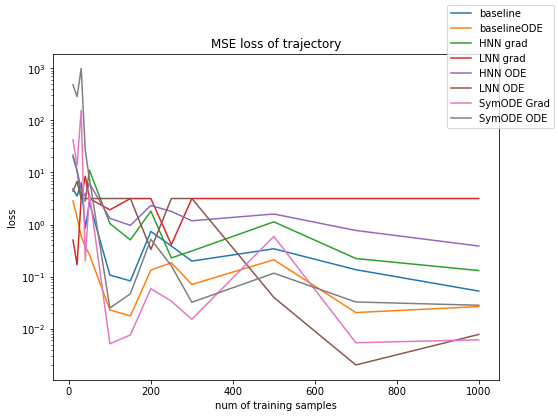

In [470]:
x = [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 500, 700, 1000]
y = np.array(test_err)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

labels = ['baseline', 'baselineODE', 'HNN grad', 'LNN grad', 'HNN ODE', 'LNN ODE', 'SymODE Grad', 'SymODE ODE']

plt.plot(x, y[:, 0], label='baseline')
plt.plot(x, y[:, 1], label='baselineODE')
plt.plot(x, y[:, 2], label='HNN grad')
plt.plot(x, y[:, 3], label='LNN grad')
plt.plot(x, y[:, 4], label='HNN ODE')
plt.plot(x, y[:, 5], label='LNN ODE')
plt.plot(x, y[:, 6], label='SymODE Grad')
plt.plot(x, y[:, 7], label='SymODE ODE')

fig.legend()
# ax.set_xlim([0, 1000])
# ax.set_ylim([0, 0.1])
ax.set_yscale('log')
ax.set_xlabel("num of training samples")
ax.set_ylabel("loss")
ax.set_title("MSE loss of trajectory")
None

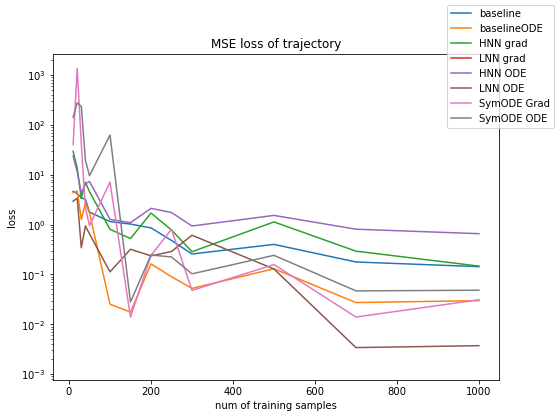

In [486]:
x = [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 500, 700, 1000]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

labels = ['baseline', 'baselineODE', 'HNN grad', 'LNN grad', 'HNN ODE', 'LNN ODE', 'SymODE Grad', 'SymODE ODE']

ax.plot(x, y_mean[:, 0], label='baseline') 
# ax.fill_between(x, y_mean[:, 0]-ci[:, 0], y_mean[:, 0]+ci[:, 0], color='b', alpha=.1)

ax.plot(x, y_mean[:, 1], label='baselineODE')
# ax.fill_between(x, y_mean[:, 1]-ci[:, 1], y_mean[:, 1]+ci[:, 1], color='b', alpha=.1)

ax.plot(x, y_mean[:, 2], label='HNN grad')
# ax.fill_between(x, y_mean[:, 2]-ci[:, 2], y_mean[:, 2]+ci[:, 2], color='b', alpha=.1)

ax.plot(x, y[1, :, 3], label='LNN grad')
# ax.plot(x, y_mean[:, 3], label='LNN grad')
# ax.fill_between(x, y_mean[:, 3]-ci[:, 3], y_mean[:, 3]+ci[:, 3], color='b', alpha=.1)

ax.plot(x, y_mean[:, 4], label='HNN ODE')
# ax.fill_between(x, y_mean[:, 4]-ci[:, 4], y_mean[:, 4]+ci[:, 4], color='b', alpha=.1)

ax.plot(x, y_mean[:, 5], label='LNN ODE')
# ax.fill_between(x, y_mean[:, 5]-ci[:, 5], y_mean[:, 5]+ci[:, 5], color='b', alpha=.1)

ax.plot(x, y_mean[:, 6], label='SymODE Grad')
# ax.fill_between(x, y_mean[:, 6]-ci[:, 6], y_mean[:, 6]+ci[:, 6], color='b', alpha=.1)

ax.plot(x, y_mean[:, 7], label='SymODE ODE')
# ax.fill_between(x, y_mean[:, 7]-ci[:, 7], y_mean[:, 7]+ci[:, 7], color='b', alpha=.1)

fig.legend()
# ax.set_xlim([0, 200])
# ax.set_ylim([0, 0.1])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("num of training samples")
ax.set_ylabel("loss")
ax.set_title("MSE loss of trajectory")
None

In [ ]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

length = 125
ax1.plot(traj[:length, 0, 0], traj[:length, 0, 1], '--', color='blue')  # traj
ax1.plot(traj[0, 0, 0], traj[0, 0, 1], marker='x', color="blue")  # init pos

ax1.plot(q_p[:length, 0], q_p[:length, 1], color='red', alpha=0.5)  # traj
ax1.plot(q_p[0, 0], q_p[0, 1], marker='x', color="red")  # init pos

ax1.set_xlim([-5., 5.])
ax1.set_ylim([-5., 5.])
ax1.set_xlabel("q")
ax1.set_ylabel("dq")
ax1.set_title("Trajectories of model dynamic")

None

In [ ]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)

length = 2000
ax1.plot(t_span, traj[:length, 0, 0], '--', color='blue')  # traj
ax1.plot(ts[:length], q_p[:length, 0], color='red', alpha=0.5)

# ax1.set_ylim([-10, 10])
ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span, traj[:length, 0, 1], '--', color='blue')  # traj
ax2.plot(ts[:length], q_p[:length, 1], color='red', alpha=0.5)

# ax2.set_ylim([-10, 10])
ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

fig.tight_layout(pad=2.0)
None

### Plot the Vector field in phase space

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
Q, P = torch.meshgrid(x, x)  # all (q, p)

# H is Hamiltonian
# (U, V) are the symplectic gradient
L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), P[i, j].reshape(1, 1)], 1)
        L[i, j] = test_model.defunc.m.L(x).detach().cpu()
        grad = test_model.defunc(0, x).detach().cpu()
        U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, P, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), P.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([P.min(), P.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagragian & Vector Field")
None

### Plot 3D surface plot of Lagrangian

In [ ]:
ground_truth = None

# Define the true Hamiltonian Here
def SHM_lagrangian(q, p, k=1., m=1.):
    return p ** 2. / (2. * m) - k * q ** 2. / 2.

ground_truth = SHM_lagrangian

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
Q, P = torch.meshgrid(x, x)  # all (q, p)

L = torch.zeros(Q.shape)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), P[i, j].reshape(1, 1)], 1)
        L[i, j] = test_model.defunc.m.L(x).detach()

# Plot the surface
surf = ax.plot_surface(Q.numpy(), P.numpy(), L.numpy(),
                       cmap='coolwarm')

if ground_truth is not None:
    L_true = ground_truth(Q, P) + L[int(n_grid / 2), int(n_grid / 2)]  # offset to see to compare
    _ = ax.plot_surface(Q.numpy(), P.numpy(), L_true.numpy(),
                        cmap='coolwarm', alpha=0.2)

# Customize the z axis.
ax.set_zlim(L.min() - 0.5, L.max() + 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(30, 30)

ax.set_title("Lagrangian Surface plot")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

None

### Plot Hamiltonian through legendre transform

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
Q, dQ = torch.meshgrid(x, x)  # all (q, p)

# H is Hamiltonian
# (U, V) are the symplectic gradient
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

P = torch.zeros_like(dQ)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
        H[i, j], P[i, j] = test_model.defunc.m.H_p_legendre(x)
        grad = test_model.defunc(0, x).detach().cpu()
        U[i, j], V[i, j] = grad[:, 0], grad[:, 1]
        
P = P.detach().numpy()

# Momentum is ambiguous here
# P_est = np.mean(P, axis=0)
# err = np.std(P, axis=0)
# P[:, 0]
# P_est = np.tile(P_est, (n_grid,1))

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, P, H.detach().numpy(), 100, cmap='RdYlBu')
fig.colorbar(CS)

# ax.streamplot(Q.T.numpy(), P_est.T, U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([P.min(), P.max()])
ax.set_xlabel("q")
ax.set_ylabel("dLddq")
ax.set_title("Hamiltonian & Vector Field")
None

### Plot Mass Matrix

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    M_est[i] = test_model.defunc.m.massMatrixNet(x[i].view(1, 1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 0.5 * 1. * x ** 2 

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    V_est[i] = test_model.defunc.m.potentialNet(x[i].view(1, 1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

## Conclusion